In [1]:
import sys
import numpy as np
from simtk import openmm, unit
from simtk.openmm import app

# Coarse-grained water system
* 3000 water molecules (1000 coarse-grained particles)
* Box size = (4 nm)^3

### LJ-12-4 potential (SDK water model)

$U(r)=\frac{3\sqrt{3}}{2}\epsilon \left( \left(\frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^4 \right) - U({r_c}), r<r_c$


In [2]:
n_particle = 1000
mass = 18*3 # dalton
sigma = 0.4371 # nm
epsilon = 0.895*4.184 # kJ/mol
box = np.array([4.0, 4.0, 4.0]) # nm

box_vectors = np.diag(box)
print(box_vectors)

[[4. 0. 0.]
 [0. 4. 0.]
 [0. 0. 4.]]


### Define OpenMM topology (in PDB convention)

In [3]:
top = app.Topology()
chain = top.addChain()
for i in range(1000):
    residue = top.addResidue('WAT', chain)
    top.addAtom('W'+str(i), None, residue)

### Create OpenMM system

In [4]:
system = openmm.System()
system.setDefaultPeriodicBoxVectors(*box_vectors)

# add particles
for i in range(1000):
    system.addParticle(mass)

# define LJ potential
lj = openmm.CustomNonbondedForce('3*sqrt(3)/2*eps*((sig/r)^12-(sig/r)^4)-Uc;'           # potential form
                                 'Uc=3*sqrt(3)/2*eps*((sig/rcut)^12-(sig/rcut)^4);'     # offset at cutoff
                                 'rcut=1.5;'                                            # cutoff distance
                                 'eps=sqrt(eps1*eps2);'                                 # geometric average for epsilon
                                 'sig=(sig1+sig2)/2;')                                  # arithmatic average for sigma
lj.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)# periodic cutoff
lj.setCutoffDistance(1.5)                                        # cutoff distance
lj.addPerParticleParameter('sig')                                # a paramter named "sig" should be provided for each particle
lj.addPerParticleParameter('eps')                                # a paramter named "eps" should be provided for each particle
for i in range(1000):
    lj.addParticle([sigma, epsilon])                             # set parameters "sig" and "eps" for each particle
system.addForce(lj)                                              # add LJ potential to the system


0

### Integrator, thermostat and barostat

In [5]:
# we are going to use Langevin integrator (thermostat)
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picosecond, 0.01*unit.picosecond)

# add a Monte Carlo barostat
# notice that barostat is termed as a "Force" object in OpenMM
barostat = openmm.MonteCarloBarostat(1.0*unit.bar, 300*unit.kelvin)                   
system.addForce(barostat)

# which platform to use
# could be 'Reference', 'CPU', 'CUDA', 'OpenCL' depending on the hardware
platform = openmm.Platform.getPlatformByName('OpenCL')

# finally we have a complete definition of the simulation system
sim = app.Simulation(top, system, integrator, platform)

# report properties and trajectory
sim.reporters.append(app.StateDataReporter(sys.stdout, 1000, temperature=True, potentialEnergy=True, step=True, density=True, separator='\t'))
sim.reporters.append(app.PDBReporter('traj.pdb', 200))

### Set the initial positions and velocities

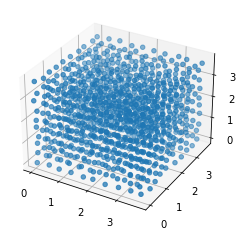

In [6]:
# generate initial positions
import itertools
positions = np.array(list(itertools.product(range(10),range(10), range(10))))/10*box
positions += np.random.rand(n_particle,3)*0.1

# let's take a look of the initial positions
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])

# notice the difference between "Simulation" and "Context"
sim.context.setPositions(positions)
sim.context.setVelocitiesToTemperature(300)

### Calculate energy

In [7]:
# use "State" to retrieve information (position, velocity, force, energy) from the system
state = sim.context.getState(getEnergy=True)
print(state.getPotentialEnergy())

87912.96875 kJ/mol


### Enenery minimization

In [8]:
sim.minimizeEnergy()
state = sim.context.getState(getEnergy=True)
print(state.getPotentialEnergy())

-30419.82421875 kJ/mol


### Run simulation

In [9]:
sim.step(10000)

#"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Density (g/mL)"
1000	-32080.67578125	293.5404214758622	1.2921651266462255
2000	-33693.6328125	316.4116493892406	1.2267970231551453
3000	-34287.6953125	299.85801201016903	1.1165903726512203
4000	-33407.75390625	281.61110490699	1.0264579435230465
5000	-32802.10546875	290.31396039756316	1.009182834792923
6000	-32436.12109375	296.80159312135606	0.9972279256186971
7000	-32267.126953125	307.2748940418564	1.0000194630050228
8000	-32138.80859375	302.57160027341774	0.9871776555050614
9000	-32351.953125	307.68499792001444	0.9996989548141911
10000	-32258.21875	304.30687552106343	0.9963475131499977


### Visualize the trajectory

In [11]:
import mdtraj
import nglview
trj = mdtraj.load('traj.pdb')
view = nglview.show_mdtraj(trj)
view.add_ball_and_stick('all')
view.center(zoom=True)
view

NGLWidget(max_frame=49)

# Another example with GROMACS input files
* 1 Na+ ion, 1 Cl- ion, and 10 water molecules
* Box size = (2.8 nm)^3

### Construct system from GROMACS files
* `conf.gro` Coordinates
* `topol.top` Topology and force field paramters

In [12]:
gro = app.GromacsGroFile('NaCl-conf.gro')
topol = app.GromacsTopFile('NaCl-topol.top', periodicBoxVectors=gro.getPeriodicBoxVectors())
system = topol.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0, constraints=app.HBonds, rigidWater=True)

### Add some interesting constraints
* Tether the Na+ ion at the center of the box
* Constrain the distance between Na+ and Cl- ions at 1 nm

In [16]:
# use "CustomExternalForce" to constrain single particle
force1 = openmm.CustomExternalForce('k*((x-1.4)^2+(y-1.4)^2+(z-1.4)^2)')
force1.addPerParticleParameter('k')
force1.addParticle(0,[100*unit.kilojoule_per_mole/unit.nanometer**2])                    # particle 0 is Na+ ion
system.addForce(force1)

# use "CustomBondForce" to constrain distance between two particles
force2 = openmm.CustomBondForce('k*(r-r0)^2')
force2.addPerBondParameter('k')
force2.addPerBondParameter('r0')
force2.addBond(0,1,[5000*unit.kilojoule_per_mole/unit.nanometer**2, 1.0*unit.nanometer]) # particle 1 is Cl- ion
system.addForce(force2)

5

### Run simulation

In [17]:
# simulation
integrator = openmm.LangevinIntegrator(500*unit.kelvin, 5/unit.picosecond, 0.0002*unit.picosecond)
platform = openmm.Platform.getPlatformByName('OpenCL')
sim = app.Simulation(topol.topology, system, integrator)
sim.reporters.append(app.StateDataReporter(sys.stdout, 2000, temperature=True, potentialEnergy=True, step=True, density=True, separator='\t'))
sim.reporters.append(app.PDBReporter('NaCl-traj.pdb', 200))

sim.context.setPositions(gro.positions)
state = sim.context.getState(getEnergy=True)
print(state.getPotentialEnergy())

sim.step(20000)

3031.4933214685498 kJ/mol
#"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Density (g/mL)"
2000	-50.863367984575234	2264.438443605366	0.01804826160015665
4000	-112.35970587520023	724.7226199729338	0.01804826160015665
6000	-280.32088751582523	438.1222542626681	0.01804826160015665
8000	-324.21639532832523	484.6905967289346	0.01804826160015665
10000	-376.04574103145023	512.768583762951	0.01804826160015665
12000	-368.32015509395023	444.2222624722134	0.01804826160015665
14000	-348.49862189082523	556.2961672903267	0.01804826160015665
16000	-372.12630743770023	458.2657847306971	0.01804826160015665
18000	-364.00521368770023	486.69419529771926	0.01804826160015665
20000	-376.34163946895023	713.7355248141531	0.01804826160015665


### Visualize

In [18]:
import mdtraj
import nglview
trj = mdtraj.load('NaCl-traj.pdb')
view = nglview.show_mdtraj(trj)
view.add_ball_and_stick('all')
view.center(zoom=True)
view

NGLWidget(max_frame=99)